# Decision Tree Classifier for IRIS Dataset

This notebook implements:
1. Data Loading and Preparation
2. Train-Test Split
3. Decision Tree Model Training
4. Hyperparameter Tuning using GridSearchCV
5. Model Evaluation
6. Model Inference
7. Model Export

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
from sklearn.tree import DecisionTreeClassifier, plot_tree

## 1. Load the Cleaned Dataset

In [2]:
# Load the cleaned dataset
df = pd.read_csv('../models/cleaned_iris_dataset.csv')

print("Dataset loaded successfully!")
print(f"Dataset Shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

# Separate features and target
X = df.drop('species', axis=1)
y = df['species']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nClass distribution:\n{y.value_counts().sort_index()}")

Dataset loaded successfully!
Dataset Shape: (149, 5)

First 5 rows:
   sepal_length  sepal_width  petal_length  petal_width  species
0           5.1          3.5           1.4          0.2        0
1           4.9          3.0           1.4          0.2        0
2           4.7          3.2           1.3          0.2        0
3           4.6          3.1           1.5          0.2        0
4           5.0          3.6           1.4          0.2        0

Features shape: (149, 4)
Target shape: (149,)

Class distribution:
species
0    50
1    50
2    49
Name: count, dtype: int64


## 2. Train-Test Split

In [3]:
# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:\n{y_train.value_counts().sort_index()}")
print(f"\nTesting set class distribution:\n{y_test.value_counts().sort_index()}")

Training set size: 119 samples
Testing set size: 30 samples

Training set class distribution:
species
0    40
1    40
2    39
Name: count, dtype: int64

Testing set class distribution:
species
0    10
1    10
2    10
Name: count, dtype: int64


## 3. Feature Scaling (Optional for Decision Trees)

In [4]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print(f"\nFeature means after scaling (should be ~0): {X_train_scaled.mean(axis=0)}")
print(f"Feature stds after scaling (should be ~1): {X_train_scaled.std(axis=0)}")

Features scaled successfully!

Feature means after scaling (should be ~0): [-5.87765131e-16  4.87005394e-16  2.78022236e-16  3.73184210e-17]
Feature stds after scaling (should be ~1): [1. 1. 1. 1.]


## 4. Baseline Decision Tree Model

In [5]:
# Train baseline Decision Tree model
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)

y_train_pred_baseline = dt_baseline.predict(X_train)
y_test_pred_baseline = dt_baseline.predict(X_test)

train_accuracy_baseline = accuracy_score(y_train, y_train_pred_baseline)
test_accuracy_baseline = accuracy_score(y_test, y_test_pred_baseline)

print('Baseline Decision Tree Model')
print('=' * 50)
print(f'Training Accuracy: {train_accuracy_baseline:.4f}')
print(f'Testing Accuracy: {test_accuracy_baseline:.4f}')

Baseline Decision Tree Model
Training Accuracy: 1.0000
Testing Accuracy: 0.9333


## 5. Hyperparameter Tuning

In [6]:
# Define parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print('Starting Grid Search...')
grid_search.fit(X_train, y_train)

print('\nGrid Search completed!')
print('=' * 50)
print(f'Best Parameters: {grid_search.best_params_}')
print(f'Best CV Score: {grid_search.best_score_:.4f}')

dt_best = grid_search.best_estimator_
y_train_pred = dt_best.predict(X_train)
y_test_pred = dt_best.predict(X_test)

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f'\nTraining Accuracy: {train_accuracy:.4f}')
print(f'Testing Accuracy: {test_accuracy:.4f}')

Starting Grid Search...
Fitting 5 folds for each of 270 candidates, totalling 1350 fits

Grid Search completed!
Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best CV Score: 0.9583

Training Accuracy: 0.9664
Testing Accuracy: 0.9333


## 6. Model Evaluation


Classification Report (Test Set)
              precision    recall  f1-score   support

      Setosa       1.00      1.00      1.00        10
  Versicolor       0.90      0.90      0.90        10
   Virginica       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



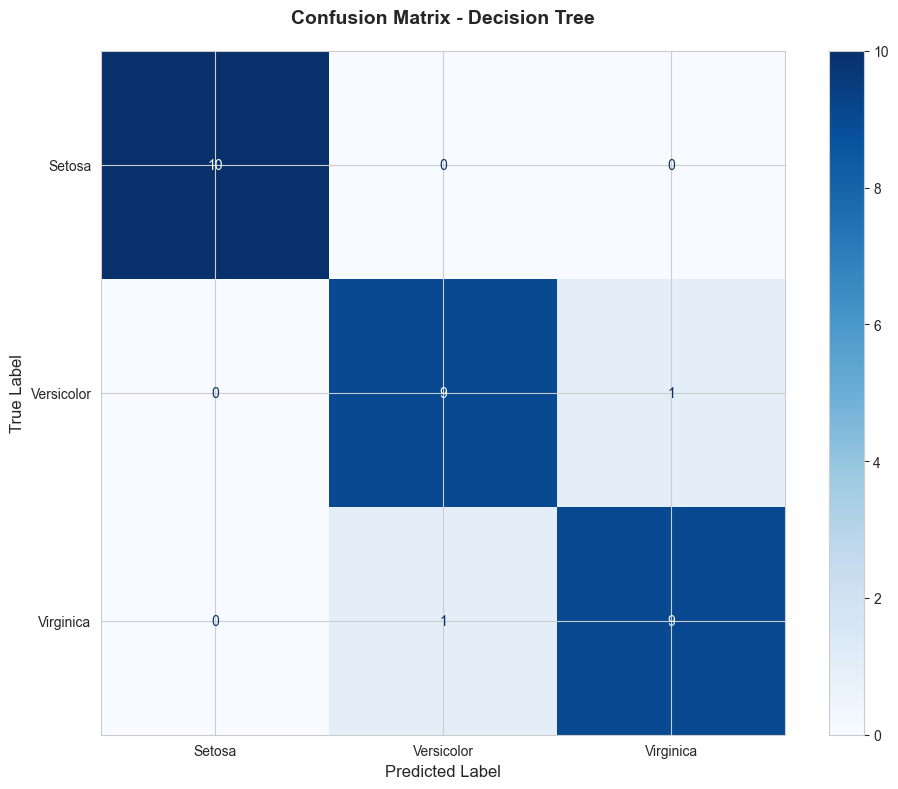


Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]


In [7]:
# Classification Report
species_names = ['Setosa', 'Versicolor', 'Virginica']

print("\nClassification Report (Test Set)")
print("=" * 50)
print(classification_report(y_test, y_test_pred, target_names=species_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

# Visualize Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_names)
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Confusion Matrix - Decision Tree', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm)

## 7. Visualize Decision Tree

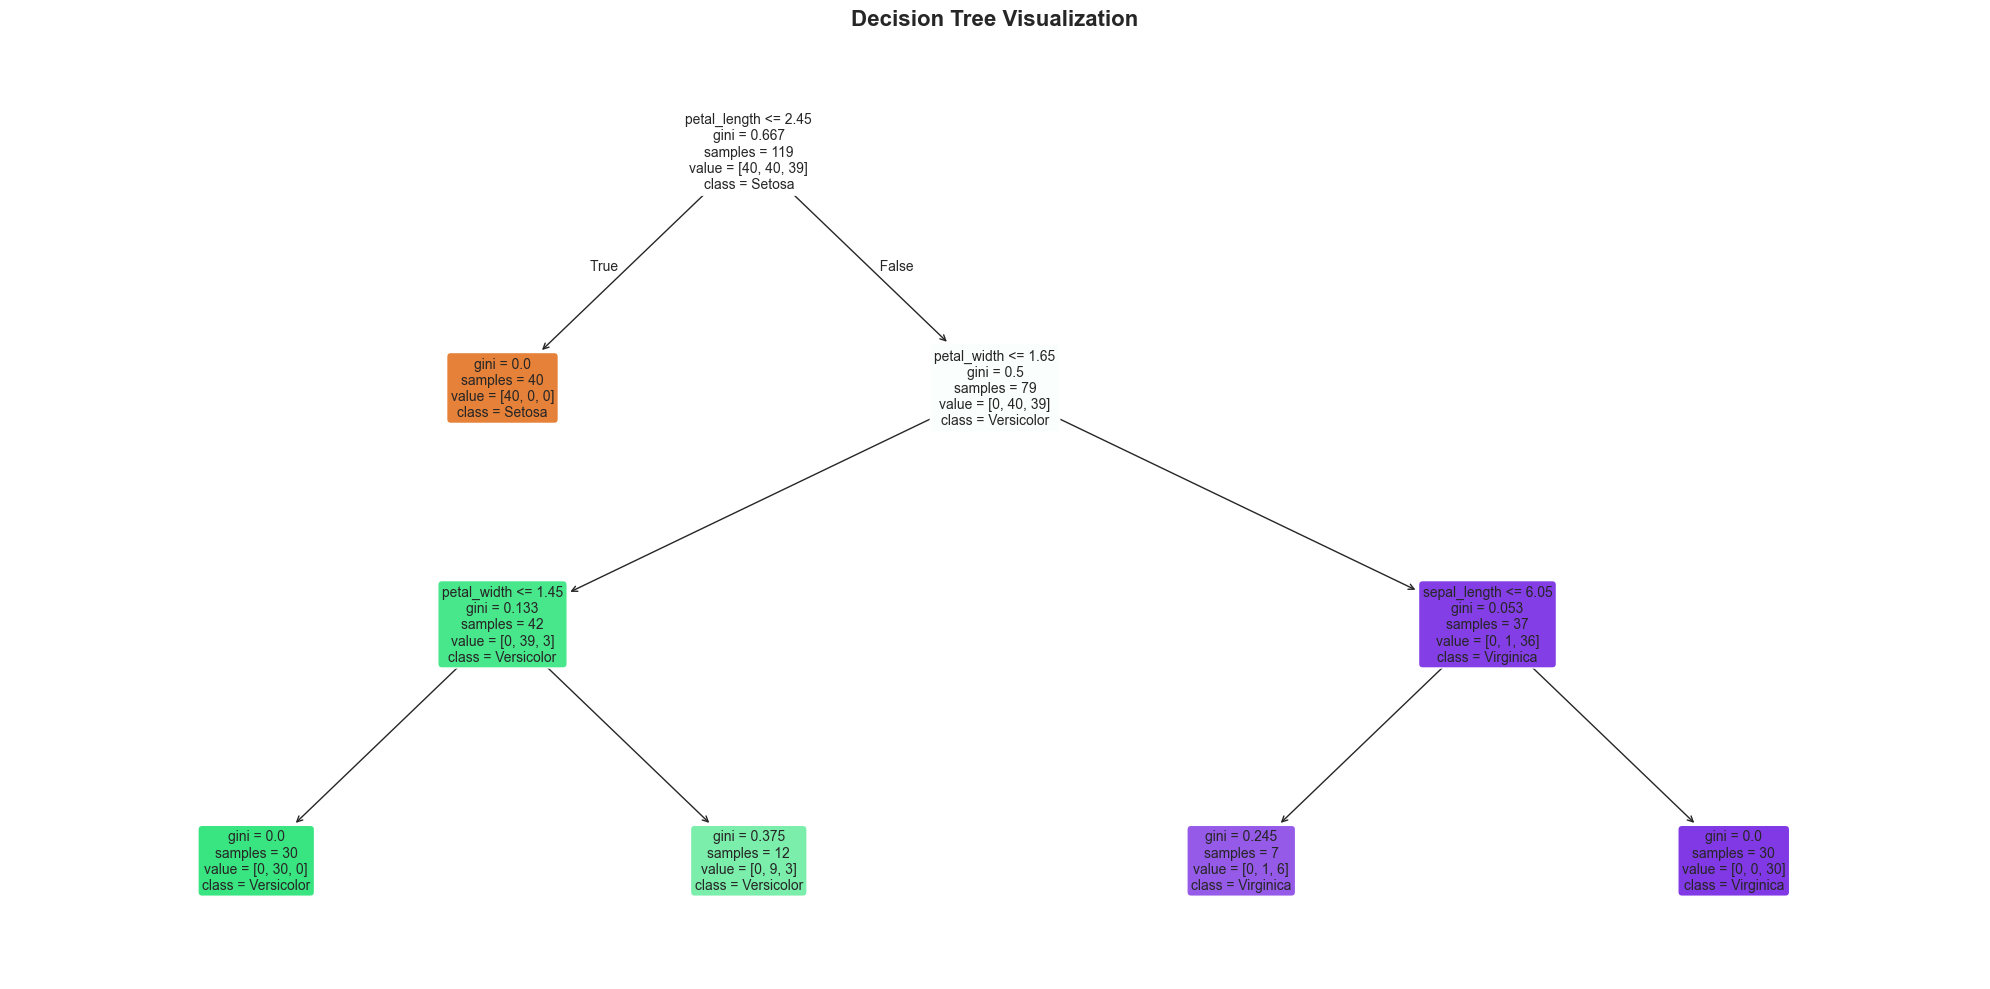

In [8]:
# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(dt_best, filled=True, feature_names=X.columns, 
          class_names=['Setosa', 'Versicolor', 'Virginica'],
          rounded=True, fontsize=10)
plt.title('Decision Tree Visualization', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 8. Feature Importance

Feature Importances:
        feature  importance
2  petal_length    0.544825
3   petal_width    0.452006
0  sepal_length    0.003169
1   sepal_width    0.000000


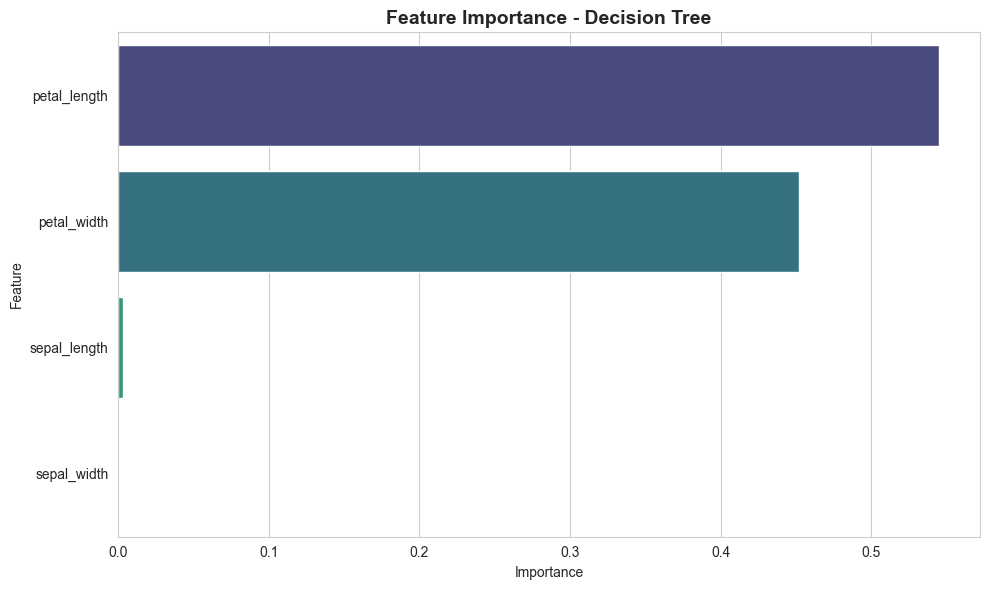

In [9]:
# Get feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_best.feature_importances_
}).sort_values('importance', ascending=False)

print('Feature Importances:')
print(feature_importance)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance, x='importance', y='feature', palette='viridis')
plt.title('Feature Importance - Decision Tree', fontsize=14, fontweight='bold')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## 9. Model Inference

In [10]:
# Test the model on new sample data
new_samples = np.array([
    [5.1, 3.5, 1.4, 0.2],  # Expected: Setosa
    [6.2, 2.9, 4.3, 1.3],  # Expected: Versicolor
    [7.3, 2.9, 6.3, 1.8]   # Expected: Virginica
])

# Scale the new samples
new_samples_scaled = scaler.transform(new_samples)

# Make predictions
predictions = dt_best.predict(new_samples_scaled)
probabilities = dt_best.predict_proba(new_samples_scaled)

print("Inference on New Samples")
print("=" * 70)
for i, (sample, pred, proba) in enumerate(zip(new_samples, predictions, probabilities)):
    print(f"\nSample {i+1}: {sample}")
    print(f"Predicted Species: {species_names[pred]}")
    print(f"Prediction Probabilities:")
    for j, species in enumerate(species_names):
        print(f"  {species}: {proba[j]:.4f}")

Inference on New Samples

Sample 1: [5.1 3.5 1.4 0.2]
Predicted Species: Setosa
Prediction Probabilities:
  Setosa: 1.0000
  Versicolor: 0.0000
  Virginica: 0.0000

Sample 2: [6.2 2.9 4.3 1.3]
Predicted Species: Setosa
Prediction Probabilities:
  Setosa: 1.0000
  Versicolor: 0.0000
  Virginica: 0.0000

Sample 3: [7.3 2.9 6.3 1.8]
Predicted Species: Setosa
Prediction Probabilities:
  Setosa: 1.0000
  Versicolor: 0.0000
  Virginica: 0.0000


## 10. Export Model

In [12]:
# Save the best model and scaler
model_data = {
    'model': dt_best,
    'scaler': scaler,
    'feature_names': list(X.columns),
    'class_names': species_names,
    'test_accuracy': test_accuracy
}

with open('../models/decision_tree_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✓ Model saved successfully to '../models/decision_tree_model.pkl'")
print(f"\nModel Details:")
print(f"  - Test Accuracy: {test_accuracy:.4f}")
print(f"  - Feature Names: {list(X.columns)}")
print(f"  - Class Names: {species_names}")

✓ Model saved successfully to '../models/decision_tree_model.pkl'

Model Details:
  - Test Accuracy: 0.9333
  - Feature Names: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
  - Class Names: ['Setosa', 'Versicolor', 'Virginica']
